### Calculate the internal heat content budget for the Baltic test case

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings

import numpy as np
import xarray as xr
from xgcm import Grid
from xhistogram.xarray import histogram
from dask.diagnostics import ProgressBar

import matplotlib.pyplot as plt
from wmt_bgc import calc_wmt as wmt

### Load grids and data

In [3]:
gridname = 'zstr' # choose from ['zstr', 'natv', 'rho2']
dt = 'daily' # choose from ['monthly', 'daily', 'hourly']

# Load data on native grid
sim = "wmt_incsurffluxes.natv_rho2_zstr.monthly_daily_hourly.13months"
rootdir = f"/archive/Graeme.Macgilchrist/MOM6-examples/ice_ocean_SIS2/Baltic_OM4_025/{sim}/Baltic_OM4_025/"
prefix = '19000101.ocean_'+dt+'_'
time = "1900_*"

# Diagnostics were saved into different files
suffixs = ['thck','heat','xtra']
Zprefixes = {'rho2':'rho2_', 'zstr':'z_', 'natv':'z'}
Zprefix = Zprefixes[gridname]
ds = xr.Dataset()
for suffix in suffixs:
    filename = prefix+gridname+'_'+suffix+'_'+time+'*.nc'
    dsnow = xr.open_mfdataset(rootdir+filename)
    ds = xr.merge([ds,dsnow])
    
# Load snapshot data (for mass tendency term)
suffix = 'snap'
filename = prefix+gridname+'_'+suffix+'_'+time+'*.nc'
snap = xr.open_mfdataset(rootdir+filename)

# Select year-long subset
ds = ds.sel(time=slice(snap.time[0], snap.time[-1]))
# ds = ds.sel(time=slice('1900-02-01 00', '1901-02-01 00'))

#  Load grid
oceangridname = '19000101.ocean_static.nc'
grid = xr.open_dataset(rootdir+oceangridname).squeeze()

# Some renaming to match hdrake conventions
ocean_grid = grid.copy().rename({'depth_ocean':'deptho'})
ds = ds.rename({'temp':'thetao'})
snap = snap.rename({'temp':'thetao'})

# Add core coordinates of ocean_grid to ds
ds = ds.assign_coords({
    "wet": xr.DataArray(ocean_grid["wet"].values, dims=('yh', 'xh',)),
    "areacello": xr.DataArray(ocean_grid["areacello"].values, dims=('yh', 'xh',)),
    "lon": xr.DataArray(ocean_grid["geolon"].values, dims=('yh', 'xh',)),
    "lat": xr.DataArray(ocean_grid["geolat"].values, dims=('yh', 'xh',)),
})

# z-coordinate dataset containing basic state variables
grid = Grid(ds, coords={'X': {'center': 'xh', 'right': 'xq'},
                        'Y': {'center': 'yh', 'right': 'yq'},
                        'Z': {'center': f'{Zprefix}l', 'outer': f'{Zprefix}i'} },
           periodic=None)

# z-coordinate dataset containing basic state variables
grid_snap = Grid(snap, coords={'X': {'center': 'xh',},
                        'Y': {'center': 'yh',},
                        'Z': {'center': f'{Zprefix}l', 'outer': f'{Zprefix}i'} },
           periodic=None)

In [5]:
snap

<xarray.Dataset>
Dimensions:   (xh: 97, yh: 105, z_l: 35, z_i: 36, time: 370)
Coordinates:
  * xh        (xh) float64 6.125 6.375 6.625 6.875 ... 29.38 29.62 29.88 30.12
  * yh        (yh) float64 53.01 53.16 53.31 53.46 ... 65.31 65.39 65.48 65.56
  * z_l       (z_l) float64 2.5 10.0 20.0 32.5 ... 5e+03 5.5e+03 6e+03 6.5e+03
  * z_i       (z_i) float64 0.0 5.0 15.0 25.0 ... 5.75e+03 6.25e+03 6.75e+03
  * time      (time) object 1900-01-02 00:00:00 ... 1901-01-06 00:00:00
Data variables:
    thetao    (time, z_l, yh, xh) float32 dask.array<chunksize=(10, 35, 105, 97), meta=np.ndarray>
    salt      (time, z_l, yh, xh) float32 dask.array<chunksize=(10, 35, 105, 97), meta=np.ndarray>
    thkcello  (time, z_l, yh, xh) float32 dask.array<chunksize=(10, 35, 105, 97), meta=np.ndarray>
    e         (time, z_i, yh, xh) float32 dask.array<chunksize=(10, 36, 105, 97), meta=np.ndarray>
    rhopot2   (time, z_l, yh, xh) float32 dask.array<chunksize=(10, 35, 105, 97), meta=np.ndarray>
Attributes:
    filename:          19000101.ocean_daily_zstr_snap_1900_01_02.nc
    title:             Baltic_OM4_025
    associated_files:  area_t: 19000101.ocean_static.nc
    grid_type:         regular
    grid_tile:         N/A

### Transform to temperature coordinates

In [6]:
# Interpolate to interface
lam = 'thetao'
tends = ['boundary_forcing_heat_tendency','internal_heat_heat_tendency',
         'opottempdiff','opottemppmdiff','frazil_heat_tendency']
lam_i = (
    grid.interp(ds[lam], "Z", boundary="extend")
    .chunk({grid.axes['Z'].coords['outer']: -1})
)
snaplam_i = (
    grid_snap.interp(snap[lam], "Z", boundary="extend")
    .chunk({grid.axes['Z'].coords['outer']: -1})
) 

# Transform tendencies
bins = np.linspace(-2,25,100)
tends_transformed = xr.Dataset()
for tend in tends:
    tends_transformed[tend] = grid.transform(
                                        ds[tend],
                                        "Z",
                                        target=bins,
                                        target_data=lam_i,
                                        method="conservative",
                                    )
# Transform boundary thickness tendency
htend_transformed = grid.transform(
                                        ds['boundary_forcing_h_tendency'],
                                        "Z",
                                        target=bins,
                                        target_data=lam_i,
                                        method="conservative",
                                    )
# Transform snapshot temperature
hsnap_transformed = grid.transform(
                                        snap['thkcello'],
                                        "Z",
                                        target=bins,
                                        target_data=snaplam_i,
                                        method="conservative",
                                    )
# 

/nbhome/gam/miniconda3/envs/wmt_bgc/lib/python3.9/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(
/nbhome/gam/miniconda3/envs/wmt_bgc/lib/python3.9/site-packages/xgcm/transform.py:247: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  out = xr.apply_ufunc(
/nbhome/gam/miniconda3/envs/wmt_bgc/lib/python3.9/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(
/nbhome/gam/miniconda3/envs/wmt_bgc/lib/python3.9/site-packages/xgcm/transform.py:247: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwar

### Cumulatively sum in lambda coordinates

In [7]:
def cumsum(da,dim,bins,greaterthan=True):
    tmp_cs = xr.concat(
        [xr.zeros_like(da.isel({dim:0})).assign_coords({dim:bins[0]}),
         da.cumsum(lam).assign_coords({dim:bins[1:]})],
        dim=dim)
    if greaterthan:
        return da.sum(dim)-tmp_cs
    else:
        return tmp_cs

In [8]:
# Tendencies
tmp = tends_transformed.weighted(ocean_grid['areacello']).sum(['xh','yh'])
tends_cumsum = cumsum(tmp,lam,bins).chunk({'time':-1,'thetao':-1})

In [10]:
rho0 = 1035.0
cp = 3992.0
dtime = ds['average_DT'].astype('timedelta64[s]')

In [11]:
# External surface forcing
tmp = htend_transformed.weighted(ocean_grid['areacello']).sum(['xh','yh'])
P_e = cumsum(tmp,lam,bins).chunk({'time':-1,'thetao':-1})
P_e = P_e*(rho0*cp)*P_e[lam]

In [12]:
# Lambda-content snapshots
tmp = (rho0*cp*hsnap_transformed*hsnap_transformed[lam]).weighted(ocean_grid['areacello']).sum(['xh','yh'])
L = cumsum(tmp,lam,bins)

In [13]:
# Volume snapshots
tmp = (hsnap_transformed).weighted(ocean_grid['areacello']).sum(['xh','yh'])
V = cumsum(tmp,lam,bins)

### Calculate internal heat content change

In [14]:
dL = L.diff('time').assign_coords({'time':ds['time']})
dV = V.diff('time').assign_coords({'time':ds['time']})
dLdt = dL/dtime.astype('float')
dVdt = dV/dtime.astype('float')
dLidt = (dLdt-rho0*cp*dVdt*dVdt[lam]).chunk({'time':-1,lam:-1})
dLidt

<xarray.DataArray (time: 369, thetao: 100)>
dask.array<rechunk-merge, shape=(369, 100), dtype=float64, chunksize=(369, 100), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 1900-01-02 12:00:00 ... 1901-01-05 12:00:00
  * thetao   (thetao) float64 -2.0 -1.727 -1.455 -1.182 ... 24.45 24.73 25.0

In [15]:
%%time
# Load the bits that are needed
with ProgressBar():
    print('Loading dLidt.')
    dLidt.load()
    print('Loading forcing terms')
    tends_cumsum.load()
    print('Loading boundary mass flux term')
    P_e.load()

Loading dLidt.
[########################################] | 100% Completed | 11.84 s
Loading forcing terms
[########################################] | 100% Completed | 40.17 s
Loading boundary mass flux term
[########################################] | 100% Completed | 7.12 sms
CPU times: user 51.4 s, sys: 53 s, total: 1min 44s
Wall time: 59.5 s


In [16]:
residual = dLidt.copy()
for term in tends_cumsum.data_vars:
    print(term)
    residual -= tends_cumsum[term]
residual += P_e

boundary_forcing_heat_tendency
internal_heat_heat_tendency
opottempdiff
opottemppmdiff
frazil_heat_tendency


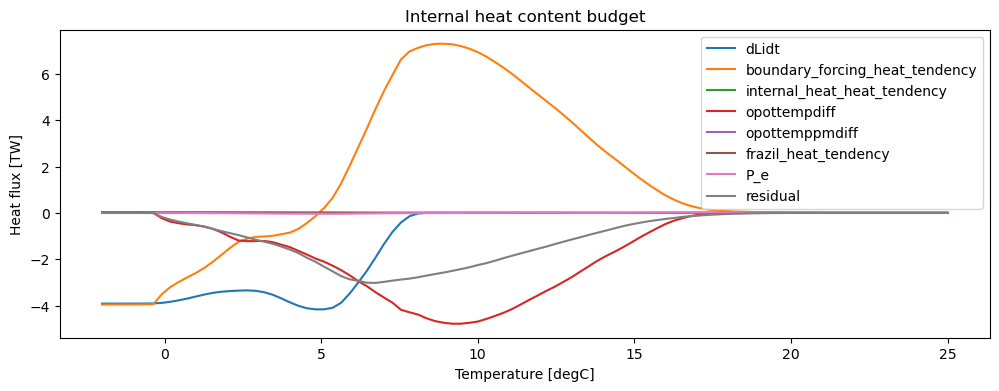

In [23]:
fig,ax = plt.subplots(figsize=(12,4))
ax.plot(dLidt[lam],dLidt.mean('time')*1e-12,label='dLidt')
for term in tends_cumsum.data_vars:
    ax.plot(tends_cumsum[term][lam],tends_cumsum[term].mean('time')*1e-12,label=term)
ax.plot(P_e[lam],P_e.mean('time')*1e-12,label='P_e')
ax.plot(residual[lam],residual.mean('time')*1e-12,label='residual')
ax.set_ylabel('Heat flux [TW]')
ax.set_xlabel('Temperature [degC]')
ax.set_title('Internal heat content budget')

ax.legend()

### Turn into a watermass transformation

In [18]:
delta_l = np.diff(bins)[0]
G = (-1/(rho0*cp))*tends_cumsum.diff(lam)/delta_l
G['residual'] = (-1/(rho0*cp))*residual.diff(lam)/delta_l

Text(0.5, 1.0, 'Watermass transformation')

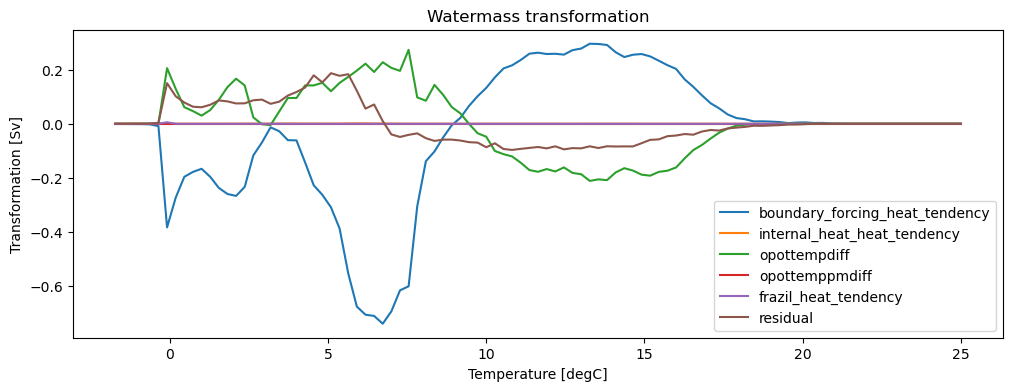

In [25]:
fig,ax = plt.subplots(figsize=(12,4))
for term in G.data_vars:
    ax.plot(G[term][lam],G[term].mean('time')*1e-6,label=term)
ax.legend()
ax.set_ylabel('Transformation [Sv]')
ax.set_xlabel('Temperature [degC]')
ax.set_title('Watermass transformation')

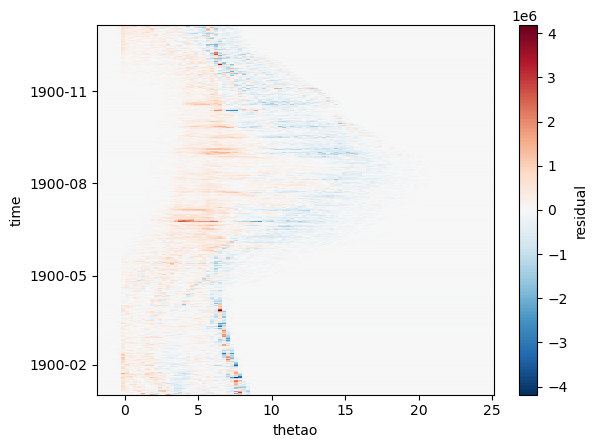

In [20]:
G['residual'].plot()

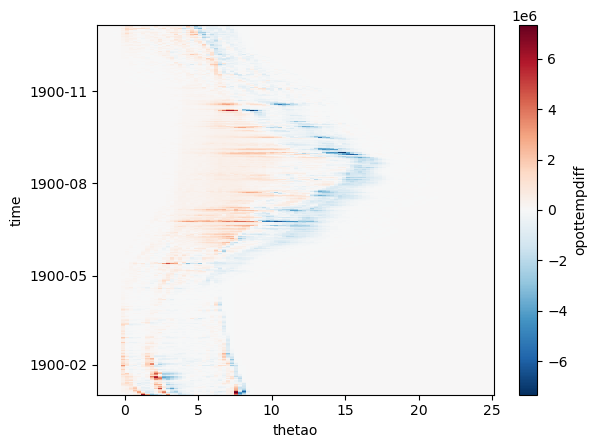

In [21]:
G['opottempdiff'].plot()